# Neural Network Potential

**prerequisites** : Pytorch

# Database construction

In [1]:
import torch as tc
import numpy as np
from torch import nn
from taps.models.torch import NeuralNetwork
from taps.models import MullerBrown
from taps.coords import Cartesian

N = 100
x = np.linspace(-0.55822365, 0.6234994, N)
y = np.linspace(1.44172582, 0.02803776, N)
coords = Cartesian(coords=np.array([x, y]))

sequential = nn.Sequential(
    nn.Linear(2, 10).double(),
    nn.SiLU().double(),
    nn.Linear(10, 10).double(),
    nn.SiLU().double(),
    nn.Linear(10, 1).double()
)
device = "cuda" if tc.cuda.is_available() else "cpu"

real_model = MullerBrown()
model = NeuralNetwork(sequential=sequential)
model.get_potential(coords=coords).shape
model(coords).shape

(100,)

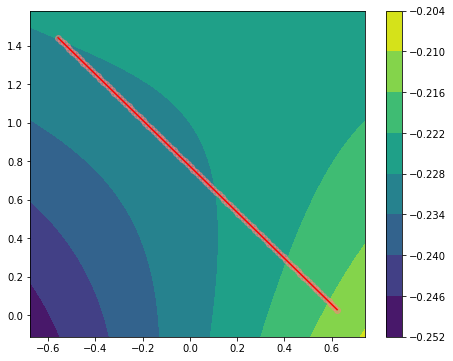

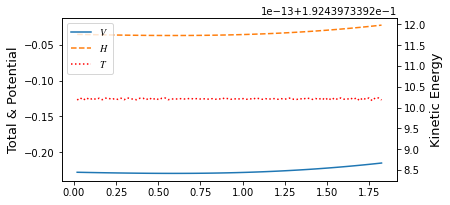

In [2]:
from taps.paths import Paths
from taps.visualize import view
paths = Paths(coords=coords, model=model)
view(paths, calculate_map=True)

In [3]:
from taps.db import ImageDatabase
from torch.utils.data import DataLoader, Dataset
from taps.models.torch import ImageDatabaseDataset
def generate_data(model, coords):
    M = len(coords)
    potential = model(coords)
    gradients = model.get_gradients(coords=coords)
    return [dict(coord=coords[m], 
                 potential=np.array([potential[m]]), 
                 gradients=gradients[..., m, np.newaxis]) for m in range(M)]

M = 100

ax, bx = np.array((-0.7, 0.7))
ay, by = np.array((-0.1, 1.5))
x = np.random.rand(M) * (bx-ax)  + ax
y = np.random.rand(M) * (by-ay)  + ay
train_coords = Cartesian(coords=np.array([x, y]))
train_coords.fluctuate(fluctuation=1)

data = generate_data(real_model, train_coords);

imgdb = ImageDatabase(filename="neuralnet2.db")
imgdb.write(data=data)

batch_size = 100
from taps.models.torch import ImageDatabaseDataset
from torch.utils.data import DataLoader
dataloader = DataLoader(ImageDatabaseDataset(imgdb), batch_size=batch_size)

In [4]:
for batch, (X, y, dy) in enumerate(dataloader):
    print(X.shape, y.view(-1, 1).shape, dy.shape)
    print(model(X).shape)
    break


torch.Size([100, 2]) torch.Size([100, 1]) torch.Size([100, 2])
torch.Size([100, 1])


In [5]:
class MSEFLoss:
    def __call__(self, predE, predF, y, dy):
        return tc.norm((predE - y)) + tc.norm((predF - dy))

loss_fn = MSEFLoss()
                       
optimizer = tc.optim.Adam(model.parameters(), lr=5e-2)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    iteration = size // dataloader.batch_size
    callback = np.arange(iteration)[[0, iteration // 2, 2*iteration//3,-1]]
    model.train()
    for batch, (X, y, dy) in enumerate(dataloader):
        X, y = X.requires_grad_(True).to(device), y.view(-1, 1).to(device)

        # Compute prediction error
        pred = model(X)
        predF = model.dV(X, pred)

#        pred.requires_grad = True
        loss = loss_fn(pred, predF, y, dy)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch in callback:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
epochs = 500
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 34.491352  [    0/  300]
loss: 42.253189  [  100/  300]
loss: 43.563964  [  200/  300]
Epoch 2
-------------------------------
loss: 33.441715  [    0/  300]
loss: 40.017052  [  100/  300]
loss: 40.116930  [  200/  300]
Epoch 3
-------------------------------
loss: 29.823687  [    0/  300]
loss: 36.588106  [  100/  300]
loss: 34.983661  [  200/  300]
Epoch 4
-------------------------------
loss: 28.397202  [    0/  300]
loss: 34.927199  [  100/  300]
loss: 32.124036  [  200/  300]
Epoch 5
-------------------------------
loss: 27.139115  [    0/  300]
loss: 31.258813  [  100/  300]
loss: 29.154647  [  200/  300]
Epoch 6
-------------------------------
loss: 26.129449  [    0/  300]
loss: 28.669897  [  100/  300]
loss: 27.813233  [  200/  300]
Epoch 7
-------------------------------
loss: 25.400254  [    0/  300]
loss: 28.122102  [  100/  300]
loss: 26.127519  [  200/  300]
Epoch 8
-------------------------------
loss: 24.778741  [    0/  300

In [6]:
epochs = 1000
optimizer = tc.optim.Adam(model.parameters(), lr=1e-4)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 2.957291  [    0/  300]
loss: 4.041854  [  100/  300]
loss: 3.303276  [  200/  300]
Epoch 2
-------------------------------
loss: 2.884657  [    0/  300]
loss: 3.933985  [  100/  300]
loss: 3.209613  [  200/  300]
Epoch 3
-------------------------------
loss: 2.816647  [    0/  300]
loss: 3.828744  [  100/  300]
loss: 3.119111  [  200/  300]
Epoch 4
-------------------------------
loss: 2.750890  [    0/  300]
loss: 3.725805  [  100/  300]
loss: 3.032556  [  200/  300]
Epoch 5
-------------------------------
loss: 2.687530  [    0/  300]
loss: 3.625440  [  100/  300]
loss: 2.950559  [  200/  300]
Epoch 6
-------------------------------
loss: 2.626778  [    0/  300]
loss: 3.527972  [  100/  300]
loss: 2.873668  [  200/  300]
Epoch 7
-------------------------------
loss: 2.568852  [    0/  300]
loss: 3.433735  [  100/  300]
loss: 2.802361  [  200/  300]
Epoch 8
-------------------------------
loss: 2.513959  [    0/  300]
loss: 3.343065  [  1

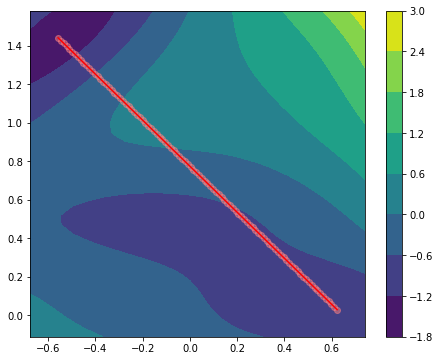

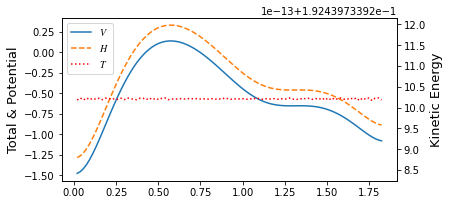

In [7]:
from taps.paths import Paths
from taps.visualize import view
paths = Paths(coords=coords, model=model)
view(paths, calculate_map=True)

In [8]:
from taps.models import Gaussian

gmodel = Gaussian(mean=model)

from taps.models.gaussian import Gaussian, Likelihood

def regression(model, database, ids=None):
    from scipy.optimize import minimize, Bounds

    loss_fn = Likelihood(kernel=model.kernel, mean=model.mean, database=database, ids=ids, kernel_prj=model.prj)
    x0 = model.kernel.get_hyperparameters()
    # sigma_f, l^2, sigma_n^e, sigma_n^f
    bounds = Bounds([1e-10, 1e-5, 1e-5, 1e-6], [5e1, 1e2, 1e-1, 1e-2])
    print(loss_fn(x0))
    res = minimize(loss_fn, x0, bounds=bounds, method='L-BFGS-B')
    model.set_lambda(database, Θk=res.x, ids=ids)

#ids=[1, 2, 3, 4, 10, 12, 15, 17]
#regression(gmodel, imgdb, ids=ids)

#gmodel.set_lambda()

#gmodel.get_potential()

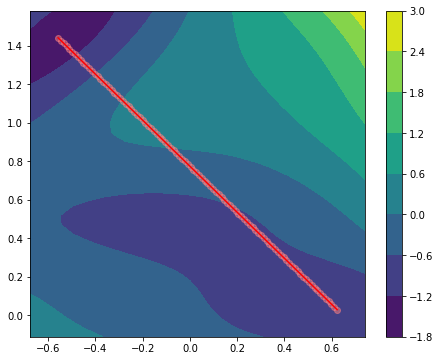

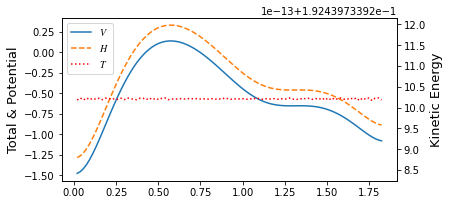

In [9]:
paths = Paths(coords=coords, model=gmodel)
view(paths, calculate_map=True)

# MullerBrown, Machine Learning only possible?

# Surrogative action optimizer (SAO)



In [55]:
class MSEFLoss:
    def __call__(self, predE, predF, y, dy):
        return tc.norm((predE - y)) + tc.norm((predF - dy))

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    iteration = size // dataloader.batch_size
    callback = np.arange(iteration)[[0, iteration // 2, 2*iteration//3,-1]]
    model.train()
    for batch, (X, y, dy) in enumerate(dataloader):
        X, y = X.requires_grad_(True).to(device), y.view(-1, 1).to(device)
        # Compute prediction error
        pred = model(X)
        predF = model.dV(X, pred)
#        pred.requires_grad = True
        loss = loss_fn(pred, predF, y, dy)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch in callback:
            loss, current = loss.item(), batch * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def all_image_method(paths):
    coords = paths.coords
    return coords

def load_dataloader(imgdb, batch_size):
    from taps.models.torch import ImageDatabaseDataset
    from torch.utils.data import DataLoader
    return DataLoader(ImageDatabaseDataset(imgdb), batch_size=batch_size)

def sao(paths):
    epochs = 100
    batch_size = 100
    iteration = np.arange(5)
    acquisition = all_image_method
    loss_fn = MSEFLoss()
    module = paths.model.mean
    optimizer = tc.optim.Adam(module.parameters(), lr=5e-2)
    
    for i in iteration:
        paths.search()
        coords = acquisition(paths)
        paths.add_image_data(coords=coords, force=True)
        dataloader = load_dataloader(paths.imgdb, batch_size)
        #####################################################
        #hyperparameters = regression(paths, loss_fn, optimizer)
        for t in range(epochs):
#            print(f"Epoch {t+1}\n-------------------------------")
            train(dataloader, module, loss_fn, optimizer)
        print("Done!")
        #paths.model.mean.set_hyperparameters(hyperparameters)
        ######################################################
#sao(paths)

In [2]:
import torch as tc
import numpy as np
from torch import nn
from taps.models.torch import NeuralNetwork
from taps.models import MullerBrown, Gaussian
from taps.coords import Cartesian
from taps.db import ImageDatabase
from taps.paths import Paths
from taps.pathfinder import DAO, GPAO
from taps.projectors import Sine

N = 100
x = np.linspace(-0.55822365, 0.6234994, N)
y = np.linspace(1.44172582, 0.02803776, N)
coords = Cartesian(coords=np.array([x, y]))

sequential = nn.Sequential(
    nn.Linear(2, 10).double(),
    nn.SiLU().double(),
    nn.Linear(10, 10).double(),
    nn.SiLU().double(),
    nn.Linear(10, 1).double()
)
device = "cuda" if tc.cuda.is_available() else "cpu"

imgdb = ImageDatabase(filename="SAO.db")

real_model = MullerBrown()
mean = NeuralNetwork(sequential=sequential)
model = Gaussian(real_model=real_model, mean=mean)

Nk = N - 50
prj = Sine(N=N, Nk=Nk, 
           init=coords.coords[..., 0].copy(), 
           fin=coords.coords[..., -1].copy())

action_kwargs = {
    'Onsager Machlup':{    
        'gam': 1.,
    },
    'Energy Restraint':{
        'muE': 1.,
        'Et': -0.45
    }
}

search_kwargs = {"method":"L-BFGS-B"}


finder = DAO(action_kwargs=action_kwargs,
             search_kwargs=search_kwargs, 
             prj=prj)

paths = Paths(coords=coords, model=model, imgdb=imgdb, finder=finder)
from taps.paths import Paths
from taps.visualize import view
#paths = Paths(coords=coords, model=model)
#view(paths, calculate_map=True, gaussian=True)

In [3]:
gradients = paths.model.get_finite_gradients(coords=paths.coords, eps=1e-4)

In [4]:
np.linalg.norm(gradients - paths.get_gradients())

1.3616222477404971e-05

In [6]:
hessian = paths.model.get_finite_hessian(coords=paths.coords, eps=1e-4)

In [7]:
np.linalg.norm(hessian - paths.get_hessian())

1.1031161777983611e-05

In [8]:
sao(paths)

      DAO Parameters
Onsager Machlup
  gam        : 1.0  
 
Energy Restraint
  muE        : 1.0  
  Et         : -0.45
 
            Iter   nfev   njev        S   dS_max
Converge :    126    132    132  30.6599   0.0260
Converge :    128    137    137  30.6599   0.0027
sigma_f    : 0.5
l^2        : 0.1
sigma_n^e  : 0.01
sigma_n^f  : 0.001
            Results
 Onsager Machlup             : 0.29060562008557855
 Energy Restraint            : 30.369257931545363
 Total S                     : 30.65986355163094
Done!
      DAO Parameters
Onsager Machlup
  gam        : 1.0  
 
Energy Restraint
  muE        : 1.0  
  Et         : -0.45
 
            Iter   nfev   njev        S   dS_max
Converge :    450    479    479   2.0330   0.0049
Converge :    454    497    497   2.0330   0.0011
Converge :    455    512    512   2.0330   0.0011
sigma_f    : 0.5
l^2        : 0.1
sigma_n^e  : 0.01
sigma_n^f  : 0.001
            Results
 Onsager Machlup             : 1.1934863174958623
 Energy Restraint     

In [12]:
tc.save(paths.model.mean.state_dict(), 'mb.tc')

In [13]:
paths.model.mean.load_state_dict(tc.load('mb.tc'))

<All keys matched successfully>

      DAO Parameters
Onsager Machlup
  gam        : 1.0  
 
Energy Restraint
  muE        : 1.0  
  Et         : -0.45
 
            Iter   nfev   njev        S   dS_max
Converge :   1429   1585   1585   1.8024   0.0011
Converge :   1432   1626   1626   1.8024   0.0006
sigma_f    : 0.5
l^2        : 0.1
sigma_n^e  : 0.01
sigma_n^f  : 0.001
            Results
 Onsager Machlup             : 1.0843970923686668
 Energy Restraint            : 0.7180062592167868
 Total S                     : 1.8024033515854536


ValueError: The number of FixedLocator locations (15), usually from a call to set_ticks, does not match the number of ticklabels (8).

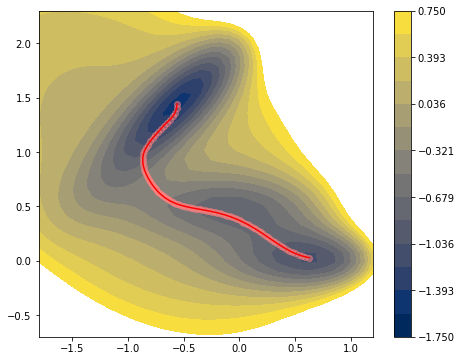

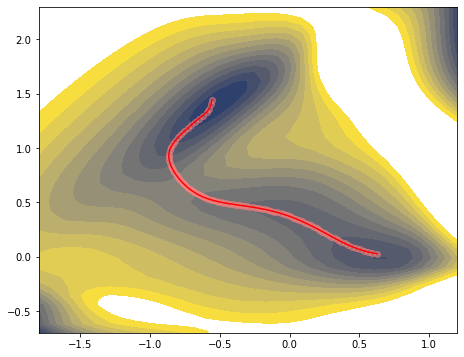

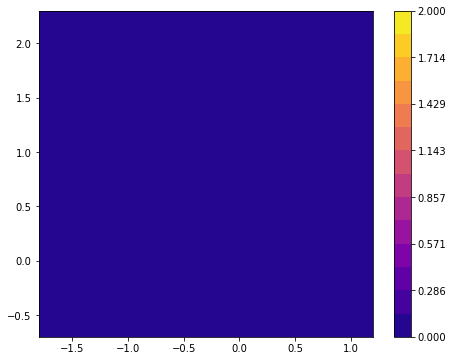

In [11]:
from taps.paths import Paths
from taps.visualize import view
#paths = Paths(coords=coords, model=model)
paths.search()
view(paths, viewer='MullerBrown', calculate_map=True, gaussian=True)

# Atomic something ssibal

""
    def __init__(self, symbols=None, Nd=None, prj=None, **kwargs):
        """
        Nd: Int
            Size of descriptor
        """
        super(AtomCenteredPyTorchKernel, self).__init__(**kwargs)
        self.symbols = symbols
        self.counter = Counter(symbols)
        self.species, self.count = zip(*self.counter.items())

        self.Nd, self.Na, self.Ns = Nd, len(self.symbols), len(self.species)
        self.partition = tc.cumsum(tc.Tensor([0, *self.count]),
                                   dim=0, dtype=int) * self.Nd
        self.prj = prj

        self.layers = []
        for sym, count in self.counter.items():
            self.layers.append(nn.Sequential(
                nn.Conv1d(self.Nd, 120, 1).double(),
                nn.ReLU().double(),
                nn.Conv1d(120, 120, 1).double(),
                nn.ReLU().double(),
                nn.Conv1d(120, 1, 1).double()
            def forward(self, tensor):
        """
        tensor: Tensor of shape (Batch, in_channel)
        """
        B, C = tensor.shape
        E = 0.
        for i in range(self.Ns):
            init, fin = self.partition[i:i+2]
            E += tc.sum(self.layers[i](tensor[:, init:fin].view(B,
                                                                self.Nd, -1)))

        return E

# Gold hopping test

In [9]:
import numpy as np
from taps.coords import Coordinate
from numpy import newaxis as nax
from numpy import concatenate
import numpy

# Atomic masses are based on:
#
#   Meija, J., Coplen, T., Berglund, M., et al. (2016). Atomic weights of
#   the elements 2013 (IUPAC Technical Report). Pure and Applied Chemistry,
#   88(3), pp. 265-291. Retrieved 30 Nov. 2016,
#   from doi:10.1515/pac-2015-0305
#
# Standard atomic weights are taken from Table 1: "Standard atomic weights
# 2013", with the uncertainties ignored.
# For hydrogen, helium, boron, carbon, nitrogen, oxygen, magnesium, silicon,
# sulfur, chlorine, bromine and thallium, where the weights are given as a
# range the "conventional" weights are taken from Table 3 and the ranges are
# given in the comments.
# The mass of the most stable isotope (in Table 4) is used for elements
# where there the element has no stable isotopes (to avoid NaNs): Tc, Pm,
# Po, At, Rn, Fr, Ra, Ac, everything after Np
# _iupac2016
atomic_masses = np.array([
    1.0,  # X
    1.008,  # H [1.00784, 1.00811]
    4.002602,  # He
    6.94,  # Li [6.938, 6.997]
    9.0121831,  # Be
    10.81,  # B [10.806, 10.821]
    12.011,  # C [12.0096, 12.0116]
    14.007,  # N [14.00643, 14.00728]
    15.999,  # O [15.99903, 15.99977]
    18.998403163,  # F
    20.1797,  # Ne
    22.98976928,  # Na
    24.305,  # Mg [24.304, 24.307]
    26.9815385,  # Al
    28.085,  # Si [28.084, 28.086]
    30.973761998,  # P
    32.06,  # S [32.059, 32.076]
    35.45,  # Cl [35.446, 35.457]
    39.948,  # Ar
    39.0983,  # K
    40.078,  # Ca
    44.955908,  # Sc
    47.867,  # Ti
    50.9415,  # V
    51.9961,  # Cr
    54.938044,  # Mn
    55.845,  # Fe
    58.933194,  # Co
    58.6934,  # Ni
    63.546,  # Cu
    65.38,  # Zn
    69.723,  # Ga
    72.630,  # Ge
    74.921595,  # As
    78.971,  # Se
    79.904,  # Br [79.901, 79.907]
    83.798,  # Kr
    85.4678,  # Rb
    87.62,  # Sr
    88.90584,  # Y
    91.224,  # Zr
    92.90637,  # Nb
    95.95,  # Mo
    97.90721,  # 98Tc
    101.07,  # Ru
    102.90550,  # Rh
    106.42,  # Pd
    107.8682,  # Ag
    112.414,  # Cd
    114.818,  # In
    118.710,  # Sn
    121.760,  # Sb
    127.60,  # Te
    126.90447,  # I
    131.293,  # Xe
    132.90545196,  # Cs
    137.327,  # Ba
    138.90547,  # La
    140.116,  # Ce
    140.90766,  # Pr
    144.242,  # Nd
    144.91276,  # 145Pm
    150.36,  # Sm
    151.964,  # Eu
    157.25,  # Gd
    158.92535,  # Tb
    162.500,  # Dy
    164.93033,  # Ho
    167.259,  # Er
    168.93422,  # Tm
    173.054,  # Yb
    174.9668,  # Lu
    178.49,  # Hf
    180.94788,  # Ta
    183.84,  # W
    186.207,  # Re
    190.23,  # Os
    192.217,  # Ir
    195.084,  # Pt
    196.966569,  # Au
    200.592,  # Hg
    204.38,  # Tl [204.382, 204.385]
    207.2,  # Pb
    208.98040,  # Bi
    208.98243,  # 209Po
    209.98715,  # 210At
    222.01758,  # 222Rn
    223.01974,  # 223Fr
    226.02541,  # 226Ra
    227.02775,  # 227Ac
    232.0377,  # Th
    231.03588,  # Pa
    238.02891,  # U
    237.04817,  # 237Np
    244.06421,  # 244Pu
    243.06138,  # 243Am
    247.07035,  # 247Cm
    247.07031,  # 247Bk
    251.07959,  # 251Cf
    252.0830,  # 252Es
    257.09511,  # 257Fm
    258.09843,  # 258Md
    259.1010,  # 259No
    262.110,  # 262Lr
    267.122,  # 267Rf
    268.126,  # 268Db
    271.134,  # 271Sg
    270.133,  # 270Bh
    269.1338,  # 269Hs
    278.156,  # 278Mt
    281.165,  # 281Ds
    281.166,  # 281Rg
    285.177,  # 285Cn
    286.182,  # 286Nh
    289.190,  # 289Fl
    289.194,  # 289Mc
    293.204,  # 293Lv
    293.208,  # 293Ts
    294.214,  # 294Og
])

class Bulk(Coordinate):
    """
    coords: N x A x G 
    
    Cells: N x 3 x 3
    """
    implemented_properties = {'masses', 'velocity', ''}
    def __init__(self, species=None, cell=None, **kwargs):
        self.species = species
        self.cell = cell
        super().__init__(**kwargs)
        
    def __getitem__(self, idx):
        return self.coords[idx]
    
    def __len__(self):
        return len(self.coords)
    
    def similar(self, coords=None, cells=None):
        return Bulk(species=self.species, coords=self.coords, cell=self.cell)
    
    def masses(self, paths, **kwargs):
        return atomic_masses[self.species.numbers][:, nax] * np.ones(self.G)
    
    def displacements(self, paths, **kwargs):
        """
        Return vector
        """
        init = self.coords[nax, 0]
        # p = coords or self.coords
        return self.coords - init

    def velocities(self, paths, coords=None, index=np.s_[:]):
        """ Return velocity at each step
        Get coords and return DxN or 3xAxN array, two point moving average.

        :math:`v[i] = (x[i+1] - x[i]) / dt`

        Parameters
        ----------
        coords : array
            size of DxN or 3xAxN
        epoch : float
            total time step.
        index : slice obj; Default `np.s_[:]`
            Choose the steps want it to be returned. Default is all steps.
        """
        if coords is None:
            p = self.coords.copy()
        else:
            p = coords
        N = self.N
        dt = self.dt
        if index == np.s_[:]:
            p = np.concatenate([p, p[nax, -1]], axis=0)
            return (p[1:] - p[:-1]) / dt
            # vel = np.diff(p, n=1, prepend=p[..., 0, nax]) / dt
            # return vel
        elif index == np.s_[1:-1]:
            return (p[2:] - p[1:-1]) / dt
        i = np.arange(N)[index]
        if i[-1] == N - 1:
            p = concatenate([p, p[nax, -1]], axis=0)
        return (p[i] - p[i - 1]) / dt

    def accelerations(self, paths, coords=None, index=np.s_[:]):
        """ Return acceleration at each step
        Get Dx N ndarray, Returns 3xNxP - 1 array, use three point to get
        acceleration

        :math:`a[i] = (2x[i] - x[i+1] - x[i-1]) / dtdt`

        Parameters
        ----------
        coords : array
            size of DxN or 3xAxN
        epoch : float
            total time step.
        index : slice obj; Default `np.s_[:]`
            Choose the steps want it to be returned. Default is all steps.
        """
        if coords is None:
            p = self.coords.copy()
        else:
            p = coords
        N = self.N
        dt = self.dt
        ddt = dt * dt
        if index == np.s_[:]:
            p = concatenate([p[nax, 0], p, p[nax, -1]], axis=0)
            return (2 * p[1:-1] - p[:-2] - p[2:]) / ddt
        elif index == np.s_[1:-1]:
            return (2 * p[1:-1] - p[:-2] - p[2:]) / ddt
        i = np.arange(N)[index]
        if i[0] == 0:
            p = concatenate([p[nax, 0], p], axis=0)
            i += 1
        if i[-1] == N - 1:
            p = concatenate([p, p[nax, -1]], axis=0)
        return (2 * p[i] - p[i - 1] - p[i + 1]) / ddt

    def get_kinetics(self, paths, properties=['kinetic_energies'],
                     return_dict=False, **kwargs):
        """
        Dumb way of calculate.. but why not.
        """
        if type(properties) == str:
            properties = [properties]

        # Make a list of requirments for minimal calulation
        irreplaceable = set()
        for prop in properties:
            if prop in ['masses', 'momentums', 'kinetic_energies',
                        'kinetic_energy_gradients']:
                irreplaceable.add('masses')
            if prop in ['displacements']:
                irreplaceable.add('displacements')
            if prop in ['velocities', 'distances', 'speeds', 'momentums',
                        'kinetic_energies']:
                irreplaceable.add('velocities')
            if prop in ['accelerations', 'kinetic_energy_gradients']:
                irreplaceable.add('accelerations')

        # Calculate
        parsed_properties = list(irreplaceable)
        parsed_results = {}
        for prop in parsed_properties:
            parsed_results[prop] = getattr(self, prop)(paths, **kwargs)

        # Name convention
        m, d, v, a = 'masses', 'displacements', 'velocities', 'accelerations'
        dt = self.dt
        # Assemble
        results = {}
        for prop in properties:
            if prop in [m, d, v, a]:
                results[prop] = parsed_results[prop]
            elif prop == 'epoch':
                results['epoch'] = self.epoch
            elif prop in ['distances', 'speeds', 'kinetic_energies']:
                if results.get(prop) is not None:
                    continue
                vv = parsed_results[v] * parsed_results[v]
                N = len(vv)
                if 'kinetic_energies' in properties:
                    mvv = parsed_results[m] * vv
                    results[prop] = 0.5 * mvv.reshape(N, -1).sum(axis=1)
                else:
                    lvl = np.sqrt(vv.reshape(N, -1).sum(axis=1))
                if 'speeds' in properties:
                    results['speeds'] = lvl
                if 'distances' in properties:
                    results['distances'] = np.add.accumulate(lvl) * dt
            elif prop in ['momentums']:
                results[prop] = parsed_results[m] * parsed_results[v]
            elif prop in ['kinetic_energy_gradients']:
                results[prop] = m * parsed_results[a]

        if len(properties) == 1 and not return_dict:
            return results[properties[0]]
        return results
    
    @property
    def G(self):
        return self.coords.shape[-1]
    
    @property
    def N(self):
        return len(self.coords)
    
    @property
    def A(self):
        return len(self.species)
    
    @property
    def D(self):
        return np.prod(self.coords.shape[1:])



In [10]:
import numpy as np
from ase.build import fcc100, add_adsorbate
from ase.calculators.emt import EMT
N = 100
init = fcc100('Al', size=(2, 2, 3))
add_adsorbate(init, 'Au', 1.7, 'hollow')
init.center(axis=2, vacuum=4.0)
init.calc = EMT()

# Final state:
fin = init.copy()
fin[-1].x += fin.get_cell()[0, 0] / 2
fin.calc = EMT()


_coords = (np.linspace(0, 1, N)[np.newaxis, np.newaxis].T * (fin.positions - init.positions) + init.positions)
coords = Bulk(species=init.symbols, cell=init.cell,
              coords=_coords)


In [11]:
from taps.models import Model
from ase.atoms import Atoms

class ASE(Model):
    
    _map = {'potential': 'energy', 'gradients': 'forces'}
    implemented_properties = {'potential', 'gradients'}
    
    def __init__(self, calc=None, **kwargs):
        self.calc = calc
        super().__init__(**kwargs)
    
    def calculate(self, coords, properties=['potential'], **kwargs):
        class_name = coords.__class__.__name__ + '_ASE'
        module = __import__('taps.models.ase', {}, None, [class_name])
        iterators = getattr(module, class_name)(coords, self.calc)

        
        ase_property = [self._map[prop] for prop in properties]
        results = {}
        for image in iterators:
            result = image.get_properties(properties=ase_property)
            for k, v in result.items():
                if results.get(k) is None:
                    results[k] = []
                results[k].append(v)
        
        for k, v in results.items():
            self.results[k] = np.array(v)
        if 'potential' in properties:
            self.results['potential'] = results['energy']
        if 'gradients' in properties:
            self.results['gradients'] = -np.array(results['forces'])
        if 'potentials' in properties:
            self.results['potentials'] = np.array(results['energies'])

real_model = ASE(calc=EMT()) 
real_model.calculate(coords=coords, properties=['potential', 'gradients'])
real_model.results['potential']

[8.560576014594984,
 8.56356614125714,
 8.56851600488644,
 8.575408867209628,
 8.584224733800479,
 8.594941433168135,
 8.607536154231354,
 8.621987021707417,
 8.63827389319841,
 8.656377536015887,
 8.67627698233163,
 8.697945878956958,
 8.721349230742112,
 8.746441583787657,
 8.773166785760443,
 8.801458759495933,
 8.831242585086962,
 8.862435425968599,
 8.89494713793395,
 8.928680595124298,
 8.96353184005038,
 8.999390164539795,
 9.036138201138174,
 9.073652075017526,
 9.111801643770793,
 9.150450837476106,
 9.189458102295578,
 9.228676945571912,
 9.26795657732599,
 9.307142641231934,
 9.346078026963985,
 9.384603754954014,
 9.422559923915262,
 9.459786710904329,
 9.496125413190883,
 9.53141952077898,
 9.565515808082539,
 9.59826543301648,
 9.62952503162916,
 9.659157796385474,
 9.687034526317703,
 9.713034637498982,
 9.73704712266263,
 9.758971449291375,
 9.778718386128523,
 9.79621074881449,
 9.811384056219229,
 9.824187090013014,
 9.834582351085162,
 9.84254640756789,
 9.8480701304

In [4]:
from taps.models.torch import AtomicNeuralNetwork
from torch import nn

sequential = nn.Sequential(
    nn.Linear(3*13, 70).double(),
    nn.SiLU().double(),
    nn.Linear(70, 1).double()
)

real_model = ASE(calc=EMT()) 

model = AtomicNeuralNetwork(sequential=sequential)

In [5]:
from taps.projectors import Sine
from taps.pathfinder import DAO
from taps.paths import Paths
from taps.db import ImageDatabase
action_kwargs = {
    'AtomicOnsager Machlup':{    
        'gam': 1.,
    },
    'AtomicEnergy Restraint':{
        'muE': 1.,
        'Et': -0.45
    }
}

search_kwargs = {"method":"L-BFGS-B"}

imgdb = ImageDatabase(filename='goldhopping2.db')
Nk = N - 50
#prj = Sine(N=N, Nk=Nk,
#           init=coords.coords[0].copy(), 
#           fin=coords.coords[-1].copy())
finder = DAO(action_kwargs=action_kwargs,
             search_kwargs=search_kwargs)
             #prj=prj)

paths = Paths(coords=coords, model=model, imgdb=imgdb, finder=finder)

In [6]:
import torch as tc
from torch.autograd.functional import jacobian
class MSEFLoss:
    def __call__(self, predE, predF, y, dy):
        return tc.norm((predE - y)) + tc.norm((predF - dy))

def dV(model, tensor):
    N, D = tensor.shape[0], np.prod(tensor.shape[1:])
    dV = tc.zeros((N, D)).double()
    for n in range(N):
        dV[n] = jacobian(model.forward, tensor[n])
    return dV

def train(dataloader, model, loss_fn, optimizer, device='cpu'):
    size = len(dataloader.dataset)
    iteration = size // dataloader.batch_size
    callback = np.arange(iteration)[[0, iteration // 2, 2*iteration//3,-1]]
    model.train()
    for batch, (X, y, dy) in enumerate(dataloader):
        X, y = X.to(device), y.view(-1, 1).to(device)
        # Compute prediction error
        pred = model(X)
        predF = dV(model, X)
#        pred.requires_grad = True
        loss = loss_fn(pred, predF, y, dy)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch in callback:
            loss, current = loss.item(), batch * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def all_image_method(paths):
    coords = paths.coords
    return coords

def load_dataloader(imgdb, batch_size):
    from taps.models.torch import ImageDatabaseDataset
    from torch.utils.data import DataLoader
    return DataLoader(ImageDatabaseDataset(imgdb), batch_size=batch_size)

def generate_data(model, coords):
    results = model.get_properties(coords=coords, properties=['potential', 'gradients'])
    potential = results['potential']
    gradients = results['gradients']
    M = len(potential)
    return [dict(coord=coords[i], potential=[potential[i]], gradients=gradients[i]) for i in range(M)]

def sao(paths):
    epochs = 100
    batch_size = 100
    iteration = np.arange(5)
    acquisition = all_image_method
    loss_fn = MSEFLoss()
    module = paths.model
    optimizer = tc.optim.Adam(module.parameters(), lr=5e-2)
    
    for i in iteration:
        paths.search()
        coords = acquisition(paths)
        data = generate_data(real_model, coords)
        imgdb.write(data=data)
        # paths.add_image_data(coords=coords, force=True)
        dataloader = load_dataloader(paths.imgdb, batch_size)
        #####################################################
        #hyperparameters = regression(paths, loss_fn, optimizer)
        for t in range(epochs):
#            print(f"Epoch {t+1}\n-------------------------------")
            train(dataloader, module, loss_fn, optimizer)
        print("Done!")
        

        #paths.model.mean.set_hyperparameters(hyperparameters)
        ######################################################
#sao(paths)
sao(paths)

      DAO Parameters
AtomicOnsager Machlup
  gam        : 1.0  
 
AtomicEnergy Restraint
  muE        : 1.0  
  Et         : -0.45
 
            Iter   nfev   njev        S   dS_max
Converge :    220    226    226 858110.7180 100.4193
Converge :    221    230    230 858110.7173 113.4316

            Results
 AtomicOnsager Machlup       : 135.9764914918962
 AtomicEnergy Restraint      : 857974.7407940199
 Total S                     : 858110.7172855118
Done!
      DAO Parameters
AtomicOnsager Machlup
  gam        : 1.0  
 
AtomicEnergy Restraint
  muE        : 1.0  
  Et         : -0.45
 
            Iter   nfev   njev        S   dS_max
Converge :    516    538    538 1006901.9797  81.4290
Converge :    517    542    542 1006901.9785 168.0336

            Results
 AtomicOnsager Machlup       : 136.18180425593147
 AtomicEnergy Restraint      : 1006765.7966691526
 Total S                     : 1006901.9784734085
Done!
      DAO Parameters
AtomicOnsager Machlup
  gam        : 1.0  
 
Atomi

# Surrogative ML potential
### Save
### Per Atomic Descriptor
### Using Descriptor

In [ ]:
class PerAtomicNeuralNetwork(nn.Module, Model):
    """
    >>>
    >>> import numpy as np
    >>> import torch
    >>> from torch import nn
    >>> from taps.models.torch import NeuralNetwork
    >>> from taps.models import MullerBrown
    >>> from taps.coords import Cartesian
    >>> N = 100
    >>> x = np.linspace(-0.55822365, 0.6234994, N)
    >>> y = np.linspace(1.44172582, 0.02803776, N)
    >>> coords = Cartesian(coords=np.array([x, y]))
    >>> sequential = nn.Sequential(
    ...     nn.Linear(2, 10).double(),
    ...     nn.SiLU().double(),
    ...     nn.Linear(10, 10).double(),
    ...     nn.SiLU().double(),
    ...     nn.Linear(10, 1).double()
    ... )
    >>> device = "cuda" if torch.cuda.is_available() else "cpu"
    >>> real_model = MullerBrown()
    >>> model = NeuralNetwork(sequential=sequential,
    ... real_model=real_model).to(device)
    >>> model.get_potential(coords=coords).shape
    >>> # model(coords).shape
    ... torch.Size([100, 1])

    """
    implemented_properties = {'potential', 'gradients', 'hessian',
                              'covariance'}

    def __init__(self, modulelist=None, **kwargs):
        super(PerAtomicNeuralNetwork, self).__init__()
        self.modulelist = modulelist
        Model.__init__(self, **kwargs)

    def __call__(self, coords):
        if isinstance(coords, Coordinate):
            coords = tc.from_numpy(coords.coords.T).double()
            return nn.Module.__call__(self, coords).detach().numpy().flatten()
        elif isinstance(coords, np.ndarray):
            coords = tc.from_numpy(coords.T).double()
            return nn.Module.__call__(self, coords).detach().numpy().flatten()

        return nn.Module.__call__(self, coords)

    def __getattr__(self, key):
        if key == 'real_model':
            return self
        else:
            return super().__getattr__(key)

    def forward(self, tensor):
        res = []
        for a in range(A):
            res.append(sequential(tensor[:, a]))
        return res

    def calculate(self, coords, properties=None, **kwargs):
        """
        coords: N x A x G
        """
        # self.eval()
        N, A, D = coords.N, coords.A, coords.D
        tensor = tc.from_numpy(
            coords.coords.reshape(N, D)).double()
        V = self.forward(tensor)
        if 'potential' in properties:
            self.results['potential'] = V.detach().numpy()[..., 0]
        if 'gradients' in properties:
            dV = tc.zeros((N, D))
            for n in range(N):
                dV[n] = jacobian(self.forward, tensor[n])
            self.results['gradients'] = dV.detach().numpy()
        if 'hessian' in properties:
            H = tc.zeros((N, D, D))
            for n in range(N):
                H[n] = hessian(self.forward, tensor[n])
            self.results['hessian'] = H.detach().numpy()
        if 'covariance' in properties:
            self.results['covariance'] = tc.zeros(N).detach().numpy()

    def dV(self, tensor):
        N, D = tensor.shape[0], np.prod(tensor.shape[1:])
        dV = tc.zeros((N, D)).double()
        for n in range(N):
            dV[n] = jacobian(self.forward, tensor[n])
        return dV

    def save_hyperparameters(self, filename):
        tc.save(self.state_dict(), filename)

    def load_hyperparameters(self, filename):
        self.load_state_dict(tc.load(filename))

In [ ]:

nn.ModuleList([])

# Atoms -> Descriptor


In [175]:
coords.get_momentums(paths).shape

(100, 13, 3)

In [ ]:
sao

In [60]:
coords[1:-1].shape

(98, 13, 3)

In [41]:
init.symbols.species()

{'Al', 'Au'}

In [37]:
list(init.symbols)

['Al', 'Al', 'Al', 'Al', 'Al', 'Al', 'Al', 'Al', 'Al', 'Al', 'Al', 'Al', 'Au']

In [33]:
model.calculate(coords)

In [35]:
list(model.results.keys())

['energy', 'natoms', 'energies', 'free_energy', 'forces', 'potential']

In [38]:
from taps.toys

Atomic(100, 13, 3)

In [32]:
a = [5]
c = [a]*4

In [34]:
a[0] = 1

In [35]:
c

[[1], [1], [1], [1]]

In [15]:
c = {'a': 4}
aaa = [1, 4, 5, c, 6, 7]

In [17]:
aaa[0] = aaa[3]

In [18]:
aaa

[{'a': 4}, 4, 5, {'a': 4}, 6, 7]

In [19]:
c['a'] =5

In [20]:
aaa

[{'a': 5}, 4, 5, {'a': 5}, 6, 7]

In [26]:
gmodel.set_lambda(imgdb, Θk=res.x)

KeyboardInterrupt: 

In [ ]:
from taps.projectors import Projector
from dscribe.descriptors import SOAP
from dscribe.descriptors import CoulombMatrix


# Some descriptors also allow calculating derivatives with respect to atomic
# positions



def _coords2images(coords):
    images = []
    for positions in coords:
        images.append(Atoms(species, positions=positions))
    return images
    
class DScribe(Projector):
    """
    soap_desc = SOAP(species=["C", "H", "O", "N"], rcut=5, nmax=8, lmax=6, crossover=True)
    """
    def __init__(self, desc=None, **kwargs):
        self.desc = desc
        super().__init__(**kwargs)
        
    @Projectors.pipeline
    def x(self, coords):
        images = _coords2images(coords)
        soap = self.desc.create(images, positions=[0])
        # oxygen_indices = [np.where(x.get_atomic_numbers() == 8)[0] for x in samples]
        # oxygen_soap = soap_desc.create(samples, oxygen_indices, n_jobs=3)
    
    def dGdx(self, coords):
        images = _coords2images(coords)
        der, des = self.desc.derivatives(images, method="auto", return_descriptor=True)

# desc = CoulombMatrix(n_atoms_max=3, permutation="sorted_l2")
#desc = SOAP(species=init.symbols.species(), rcut=6, nmax=4, lmax=4, crossover=True)
#prj = DScribe(desc=desc)
#prj.x(coords)

# Model image create

# Draw Surface lee jy
# 세로 그림
# dr